# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import gc

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

In [5]:
ls

LUFlow/


# Downloading, Reading and Merging Data

In [6]:
def move_directories(orig_path, dest_path):
    # Check if the destination folder exists, otherwise create it
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Iter over all files and folders in the source directory
    for item in os.listdir(orig_path):
        orig_item_path = os.path.join(orig_path, item)
        
        # Check if it is a folder
        if os.path.isdir(orig_item_path):
            # Defines the destination path for the folder
            dest_item_path = os.path.join(dest_path, item)
            
            # Move the folder by renaming it
            os.rename(orig_item_path, dest_item_path)
            print(f"Moved directory: {orig_item_path} -> {dest_item_path}")

In [7]:
import kagglehub

# Check if some subdirectories are not empty
path_to_check = "./LUFlow/"
subdirs = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
non_empty_subdirs = [d for d in subdirs if os.listdir(os.path.join(path_to_check, d))]

dest_path = './LUFlow'

if non_empty_subdirs:
    print("Non-empty subdirectories:", non_empty_subdirs)
    print("Skip downloading.")
else:
    print("All subdirectories are empty.")
    print("Download dataset.")

    # Download latest version
    path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

    print("Path to dataset files:", path)

    move_directories(path, dest_path)

Non-empty subdirectories: ['2021', '2020', '2022']
Skip downloading.


/home/ubdeskiovaro/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
encoded_dataset = './LUFlow/encoded_dataset.csv'

if os.path.isfile(encoded_dataset):
    print("Encoded dataset is in the directory.")
    ENCODED = True
else:
    print("Encoded dataset is not in the directory.")
    ENCODED = False

Encoded dataset is in the directory.


In [9]:
if not ENCODED:

    df_list = []
    i = 0

    selected_columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']
    dtype_dict = {'bytes_in': np.int32, 'bytes_out': np.int32, 'num_pkts_out': np.int32, 
                  'num_pkts_in': np.int32, 'proto': np.int32, 'time_start': np.int64, 'label': str}

    for root, dirs, files in os.walk(dest_path):
        for file in files:
            # checks if 'file' does not exist in the directory
            # checks if 'csv' is in the file name
            # checks if a particular string is in the file name
            if not os.path.isfile(file) and 'csv' in file:
                chunk_iter = pd.read_csv(os.path.join(root, file), chunksize=10000, usecols=selected_columns, dtype=dtype_dict)
                for chunk in chunk_iter:
                    df_list.append(chunk)
                
                del chunk_iter
                gc.collect()
                i += 1

    df = pd.concat(df_list, ignore_index=True)

    del df_list
    gc.collect()

In [10]:
sorted_dataset = './LUFlow/sorted_encoded_dataset.csv'

if os.path.isfile(sorted_dataset) and ENCODED:
    print("Sorted dataset is in the directory.")
    # dataset_encoded_sorted = pd.read_csv(sorted_dataset)
else:
    print("Sorting dataset.")

    dataset_encoded = pd.read_csv(encoded_dataset)
    dataset_encoded_sorted = dataset_encoded.sort_values(by=['time_start'])

    dataset_encoded_sorted.to_csv(sorted_dataset, index=False)

Sorted dataset is in the directory.


In [11]:
QUART = True

if ENCODED and QUART:
    import pandas as pd

    # Count number of lines in the file
    with open(sorted_dataset) as f:
        total_rows = sum(1 for _ in f) - 1  # exclude header

    # Compute the fraction
    n_quarter_rows = total_rows // 8

    # Load only first quarter of the dataset
    df = pd.read_csv(sorted_dataset, nrows=n_quarter_rows)

# Exploratory Data Analysis

In [12]:
import matplotlib.pyplot as plt

if not ENCODED:
    # Count the occurrences of each label
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

    # Show the plot
    plt.title('Distribution of Labels')
    plt.show()

# Data Preprocessing

In [13]:
df.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()
print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [14]:
if not ENCODED:
    df = df[df['label'].isin(['benign', 'malicious'])].copy()

    df = df.reset_index(drop=True)

In [15]:
from sklearn.preprocessing import LabelEncoder

if not ENCODED:
    label_encoder = LabelEncoder()

    # Fit and transform the label column
    df['label'] = label_encoder.fit_transform(df['label'])

In [16]:
if not ENCODED:
    df.to_csv(encoded_dataset, index=False)

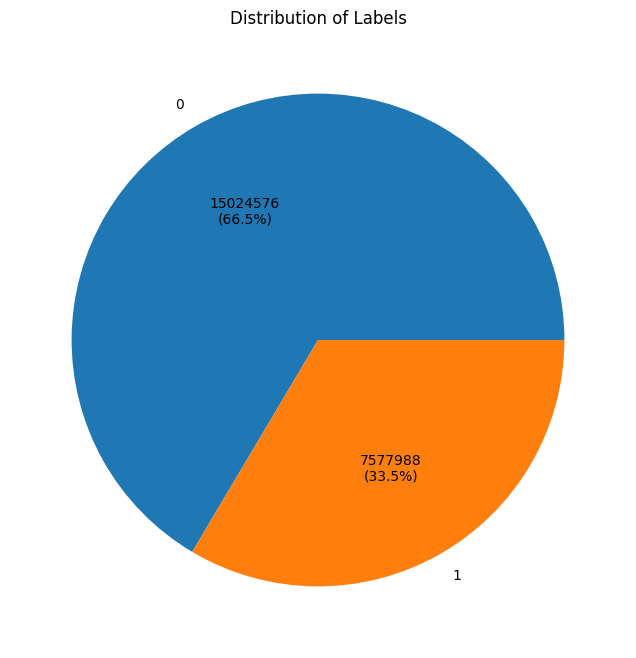

In [17]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [18]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

## Construction of Interval Information Granules

### Selecting index using time windows

In [19]:
perc = 0.8

rows_perc = int(len(df)*perc)

df_test = df.iloc[rows_perc:]
df_train = df.iloc[:rows_perc]

In [20]:
from tqdm import tqdm

time_slices = [16, 128, 256, 1024, 2048, 3016]

matching_indices_slices = {}

time_start_values = df['time_start'].values
n = time_start_values

for ts in tqdm(time_slices):
  # maximum time limit of the granule
  limit = time_start_values[0] + ts

  # number of groups for time_slice
  num_group = 0
  group_dict = {num_group:[0]}

  for i in range(1, len(n)):
      # if the value of time_start is greater than limit then limit is updated and
      # it is initilized a new group otherwise the index of the row is added to group_dict
      if time_start_values[i] >= limit:
        limit = time_start_values[i] + ts
        num_group += 1

        group_dict[num_group] = [i]
      else:
        group_dict[num_group].append(i)
  
  matching_indices_slices[ts] = group_dict
  del group_dict
  gc.collect()

100%|██████████| 6/6 [03:19<00:00, 33.19s/it]


### Drop Label column

In [21]:
# Separate features (X) and target variable (y)
X_train = df.loc[:, df.columns != 'label']
y_train = df['label']

del df
gc.collect()

0

In [22]:
# Separate features (X) and target variable (y)
X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']


del df_test
gc.collect()

0

In [23]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
0,0,7430,6,0,6,15925366400
1,0,10136,7,0,6,15925373126
2,0,2985,3,2,6,15925397203
3,0,5792,4,2,6,15925398899
4,0,3548,3,0,6,15925416267
...,...,...,...,...,...,...
22602560,0,7240,5,5,6,1592801271843816
22602561,7240,0,5,5,6,1592801271843913
22602562,0,10136,7,3,6,1592801271844032
22602563,0,11584,8,1,6,1592801271844083


In [24]:
y_train

0           0
1           0
2           0
3           0
4           0
           ..
22602560    0
22602561    0
22602562    0
22602563    0
22602564    0
Name: label, Length: 22602565, dtype: int64

### Creating interval information granules

with justifiable granularity principle


implementing both 'a' and 'b' to define the frames to include in the granule

In [ ]:
# import math

# # pd_ab_changes = pd.DataFrame(columns=['time_slice', 'group', 'a', 'b', 'V_a_opt', 'V_b_opt'])
# # pd_ab_changes.to_csv('../ab_changes.csv', index=False)


# X_train_granule = {}
# y_train_granule = {}

# alpha = 2.0
# l = 100

# for time_slice in time_slices:
#   X_train_granule[time_slice] = {}
#   y_train_granule[time_slice] = {}


#   for group in tqdm(matching_indices_slices[time_slice]):

#     # obtains index for previous defined groups
#     group_indeces = matching_indices_slices[time_slice][group]

#     group_data = X_train.iloc[group_indeces]

#     N = len(group_data)

#     # if the slice has only one element, the granule is the element itself
#     if N == 1:
#       X_train_granule[time_slice][group] = group_data
#       y_train_granule[time_slice][group] = y_train.iloc[X_train_granule[time_slice][group].index]
#       continue
    
#     y_min = group_data['time_start'].min()
#     y_max = group_data['time_start'].max()

#     diff = y_max - y_min
#     y_max_rel = y_max - y_min

#     m = group_data['time_start'].mean()
#     m_rel = m - y_min

#     # delta_y = (y_max - m)/l
#     delta_y = (y_max_rel - m_rel)/l

#     V_b_opt = float('-inf')
#     V_a_opt = float('-inf')

#     for h in range(0, l):
#       b_rel = m_rel+h*delta_y
#       a_rel = m_rel-h*delta_y

#       b = y_min + b_rel
#       condition_b = (group_data['time_start'] > m) & (group_data['time_start'] <= b)
#       cov_b = len(condition_b)/N
#       sp_b = math.exp(-alpha*abs(m_rel-b_rel))

#       a = y_min + a_rel
#       condition_a = (group_data['time_start'] > a) & (group_data['time_start'] <= m)
#       cov_a = len(condition_a)/N
#       sp_a = math.exp(-alpha*abs(a_rel-m_rel))

#       V_b = cov_b*sp_b
#       V_a = cov_a*sp_a

#       if V_a > V_a_opt:
#         a_opt = a
#         V_a_opt = V_a

#       if V_b > V_b_opt:
#         b_opt = b
#         V_b_opt = V_b

#       # print(f"a: {a}, b: {b}, V_a: {V_a}, V_b: {V_b}, V_a_opt: {V_a_opt}, V_b_opt: {V_b_opt}")
#       # print(f"cov_a: {cov_a}, sp_a: {sp_a}, V_a_opt: {V_a_opt}, a: {a}, a_opt: {a_opt}")
#       # row = {'time_slice': time_slice, 'group': group, 'a': a, 'b': b, 'V_a_opt': V_a_opt, 'V_b_opt': V_b_opt}
#       # row = pd.DataFrame([row])
#       # row.to_csv('../ab_changes.csv', mode='a', header=False, index=False)

#     condition = (group_data['time_start'] > a_opt) & (group_data['time_start'] <= b_opt)
#     filtered_granule = group_data[condition]

#     # Make sure the granule is not empty
#     if filtered_granule.empty:
#       continue  # Skip this group if no data fits the condition

#     X_train_granule[time_slice][group] = filtered_granule

#     # Extract the selected rows
#     selected_rows = y_train.iloc[filtered_granule.index]

#     # Find the most frequent value (mode)
#     most_frequent_value = selected_rows.mode().iloc[0]

#     # Assign the modal value to all selected rows
#     y_train.iloc[filtered_granule.index] = most_frequent_value
#     y_train_granule[time_slice][group] = y_train.iloc[filtered_granule.index]

#     del group_data
#     gc.collect()

 82%|████████▏ | 17403158/21120447 [7:44:56<28:22, 2183.34it/s]   

In [ ]:
# print(f"y_max: {y_max}\n y_min: {y_min}\n diff: {diff}\n y_max_rel: {y_max_rel}\n m: {m}\n m_rel: {m_rel}\n delta_y: {delta_y}")

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

alpha = 2.0
l = 100
delta_y_factor = 1 / l

# Pre-alloca memoria per risultati
X_train_granule = {time_slice: {} for time_slice in time_slices}
y_train_granule = {time_slice: {} for time_slice in time_slices}

def process_group(group):
    group_indeces = matching_indices_slices[time_slice][group]
    group_data = X_train.iloc[group_indeces]
    N = len(group_data)

    if N == 1:
        return group, group_data, y_train.iloc[group_data.index]

    stats = group_data['time_start'].agg(['min', 'max', 'mean'])
    y_min, y_max, m = stats['min'], stats['max'], stats['mean']

    delta_y = (y_max - m) * delta_y_factor
    m_rel = m - y_min

    V_b_opt, V_a_opt = float('-inf'), float('-inf')
    a_opt, b_opt = None, None

    for h in range(0, l):
        b_rel = m_rel + h * delta_y
        a_rel = m_rel - h * delta_y
        b, a = y_min + b_rel, y_min + a_rel

        cov_b = ((group_data['time_start'] > m) & (group_data['time_start'] <= b)).sum() / N
        cov_a = ((group_data['time_start'] > a) & (group_data['time_start'] <= m)).sum() / N

        sp_b = np.exp(-alpha * abs(m_rel - b_rel))
        sp_a = np.exp(-alpha * abs(a_rel - m_rel))

        V_b = cov_b * sp_b
        V_a = cov_a * sp_a

        if V_a > V_a_opt:
            a_opt, V_a_opt = a, V_a

        if V_b > V_b_opt:
            b_opt, V_b_opt = b, V_b

    condition = (group_data['time_start'] > a_opt) & (group_data['time_start'] <= b_opt)
    filtered_granule = group_data[condition]

    if filtered_granule.empty:
        return group, None, None

    selected_rows = y_train.iloc[filtered_granule.index]
    most_frequent_value = selected_rows.mode().iloc[0]
    y_train.iloc[filtered_granule.index] = most_frequent_value

    return group, filtered_granule, y_train.iloc[filtered_granule.index]

# Parallelizza il ciclo sui gruppi
for time_slice in time_slices:
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_group, matching_indices_slices[time_slice]))

    for group, granule, y_granule in results:
        if granule is not None:
            X_train_granule[time_slice][group] = granule
            y_train_granule[time_slice][group] = y_granule

    gc.collect()


### Training of Random Forest models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

list_reports = {}
best_models = {}
bcc_reports = {}

mcc_reports = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')


for time_slice in tqdm(time_slices):
  y_train_list = pd.concat(y_train_granule[time_slice].values(), ignore_index=True)
  X_train_granule_df = pd.concat(X_train_granule[time_slice].values(), ignore_index=True)

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(X_train_granule_df, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True)

  tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()

  # Calculate MCC avoiding overflow
  numerator = tp * tn - fp * fn
  terms = [tp + fp, tp + fn, tn + fp, tn + fn]
  log_denominator = sum(np.log(term) for term in terms if term > 0) 
  
  if log_denominator > 0:
      mcc_reports[time_slice] = numerator / np.exp(0.5 * log_denominator)
  else:
      mcc_reports[time_slice] = 0  # Use a fallback value for zero/invalid denominator

  bcc_reports[time_slice] = (tp/(tp+fn) + tn/(tn+fp))/2

  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model

# Model Performance

The performance metrics used by the approach proposed in [8]:
-	Accuracy is the proportion of accurately classified datapoints in the test set in relation to the total number of instances.
-	Precision is the ratio of detected positive cases to all expected positive instances.
-	Recall is the ratio of samples classified as positive to all expected positive instances.
-	F1-score is a harmonic mean of recall and precision.
-	MCC (Matthews Correlation Coefficient) determines the correlation coefficient between the anticipated and actual classifications.
-	BCC (Balanced Accuracy) is used for situations with data imbalance.

In [24]:
# Go up one directory
os.chdir('..')

# Check if 'reports' directory exists, otherwise create it
if not os.path.exists('reports'):
    os.mkdir('reports')

# Check if 'best_models' directory exists, otherwise create it
if not os.path.exists('best_models'):
    os.mkdir('best_models')

In [25]:
import time
import joblib

subset = 'all'
string = 'justifiablegranularity_'+subset+'_'+time.strftime("%Y%m%d-%H%M%S")

os.mkdir(f'./reports/{string}')
os.mkdir(f'./best_models/{string}')

os.chdir(f'./reports/{string}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')

# for bcc in bcc_reports:
#   with open(f'bcc_{bcc}.txt', 'w') as f:
#     f.write(str(bcc_reports[bcc]))

# for mcc in mcc_reports:
#   with open(f'mcc_{mcc}.txt', 'w') as f:
#     f.write(str(mcc_reports[mcc]))

columns = ['time_slice', 'BCC', 'MCC']
df = pd.DataFrame(columns=columns)
for bcc, mcc, time_slice in bcc_reports, mcc_reports, time_slices:
  row = {'time_slice': time_slice, 'BCC': bcc_reports[bcc], 'MCC': mcc_reports[mcc]}
  row = pd.DataFrame([row])
  row.to_csv('bcc_mcc.csv', mode='a', header=False, index=False)


os.chdir(f'../../best_models/{string}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{string}.joblib')

In [ ]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
plt.show()

In [ ]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}\n')
  print(f'BCC {time_slice}: {bcc_reports[time_slice]}\n')
  print(f'MCC {time_slice}: {mcc_reports[time_slice]}')
  print('\n')